In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"pujahbalu","key":"142bc8cd0e9a95bd361cd2c93b135f7a"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!unzip fake-and-real-news-dataset.zip -d fake_news_data

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
Archive:  fake-and-real-news-dataset.zip
  inflating: fake_news_data/Fake.csv  
  inflating: fake_news_data/True.csv  


In [10]:
!pip install nltk scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Load datasets
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

# Add labels
true_df['label'] = 1
fake_df['label'] = 0

# Combine
df = pd.concat([true_df, fake_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle
df.head()

,title,text,subject,date,label
0,Anti-elite Slovene presidential candidate seen...,LJUBLJANA (Reuters) - Anti-establishment Slove...,worldnews,"November 13, 2017",1
1,Trump and U.S. House tax lawmaker reopen door ...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"October 25, 2017",1
2,"ICAN elated at Nobel Peace Prize, pays tribute...",GENEVA (Reuters) - A spokeswoman for Internati...,worldnews,"October 6, 2017",1
3,Erdogan says Turkey will destroy those in Syri...,ANKARA (Reuters) - President Tayyip Erdogan sa...,worldnews,"December 5, 2017",1
4,No formal U.S. delegation to Castro memorial: ...,WASHINGTON (Reuters) - The United States will ...,politicsNews,"November 29, 2016",1


In [12]:
import re
stop_words = stopwords.words('english')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # remove non-letter chars
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['text'] = df['title'] + " " + df['text']
df['text'] = df['text'].apply(clean_text)

In [13]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
tfidf = TfidfVectorizer(max_df=0.7)
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [16]:
model = PassiveAggressiveClassifier(max_iter=50)
model.fit(tfidf_train, y_train)

PassiveAggressiveClassifier(max_iter=50)

Accuracy: 0.995879732739421

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      4685
           1       0.99      1.00      1.00      4295

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



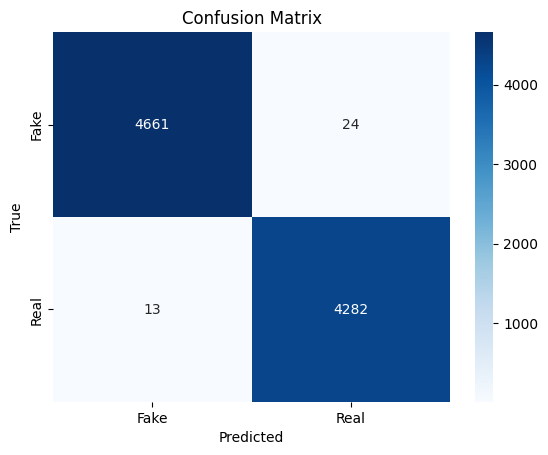

In [17]:
y_pred = model.predict(tfidf_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()